# CRND vs Baselines Head-to-Head Noise Detection Evaluation

**Comprehensive comparison of CRND (Cross-Representation Neighborhood Disssonance) against baseline noise detection methods.**

This notebook reproduces the statistical evaluation pipeline that compares CRND against 11 baselines (kDN, cleanlab, k-NN consistency, random) across multiple clinical text datasets and noise rates. It computes:

- **ROC-AUC comparisons** with Welch's t-tests and bootstrap confidence intervals
- **Effect sizes** (Cohen's d) with DerSimonian-Laird meta-analysis
- **Boundary stratification** analysis (interior vs boundary instances)
- **Schoener's D** 2D vs 5D sensitivity comparison
- **Per-class CRND** distribution analysis with Kruskal-Wallis tests
- **Computational cost** comparison

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# No non-Colab packages needed — all imports are from stdlib + numpy + scipy

# numpy, scipy, matplotlib — pre-installed on Colab, install locally only
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'scipy==1.16.3', 'matplotlib==3.10.0', 'tabulate==0.9.0')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


## Imports

In [2]:
import json
import re
import time
import warnings
from copy import deepcopy
from typing import Any

import numpy as np
from scipy import stats as sp_stats
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({"font.size": 11})

warnings.filterwarnings("ignore", category=RuntimeWarning)

## Data Loading

Load pre-computed evaluation data (CRND and baseline metrics across datasets and noise rates).

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-e0166a-cross-representation-neighborhood-disson/main/evaluation_iter3_crnd_vs_baselin/demo/mini_demo_data.json"
import json, os

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded data with keys: {list(data.keys())}")
print(f"Datasets: {data['config']['datasets']}")
print(f"Baselines: {data['config']['baselines']}")
print(f"Noise rates: {data['config']['noise_rates']}")

Loaded data with keys: ['crnd_aggregates', 'baseline_aggregates', 'statistical_comparisons', 'boundary_stratification', 'schoeners_d_sensitivity', 'per_class_crnd', 'meta_analysis', 'computational_cost', 'niche_overlap_profiles', 'metrics_agg', 'datasets', 'config']
Datasets: ['medical_abstracts', 'mental_health_conditions']
Baselines: ['kdn_tfidf', 'cleanlab_embed', 'random']
Noise rates: [0.05, 0.1, 0.2]


## Configuration

Tunable parameters for the evaluation. `BOOTSTRAP_N` controls the number of bootstrap resamples for confidence intervals (higher = more precise but slower).

In [5]:
# --- Tunable parameters ---
BOOTSTRAP_N = 10_000  # Original value (10k bootstrap resamples)
BOOTSTRAP_SEED = 42
ALPHA = 0.05

# Dataset and baseline configuration (from loaded data)
DATASETS = data["config"]["datasets"]
NOISE_RATES = [str(nr) for nr in data["config"]["noise_rates"]]
UNIQUE_BASELINES = data["config"]["baselines"]

print(f"BOOTSTRAP_N = {BOOTSTRAP_N}")
print(f"DATASETS = {DATASETS}")
print(f"NOISE_RATES = {NOISE_RATES}")
print(f"UNIQUE_BASELINES = {UNIQUE_BASELINES}")

BOOTSTRAP_N = 10000
DATASETS = ['medical_abstracts', 'mental_health_conditions']
NOISE_RATES = ['0.05', '0.1', '0.2']
UNIQUE_BASELINES = ['kdn_tfidf', 'cleanlab_embed', 'random']


## Helper Functions

Core statistical functions: Welch's t-test, Cohen's d, bootstrap CI, Wilcoxon test, and DerSimonian-Laird meta-analysis.

In [6]:
def welch_t_test(
    mean1: float, std1: float, n1: int,
    mean2: float, std2: float, n2: int,
) -> dict:
    """Welch's t-test from summary statistics."""
    se1_sq = (std1 ** 2) / n1 if n1 > 0 else 0
    se2_sq = (std2 ** 2) / n2 if n2 > 0 else 0
    se_diff = np.sqrt(se1_sq + se2_sq)
    if se_diff == 0:
        return {"t_stat": 0.0, "p_value": 1.0, "df": 0.0}
    t_stat = (mean1 - mean2) / se_diff
    # Welch-Satterthwaite degrees of freedom
    num = (se1_sq + se2_sq) ** 2
    denom = 0.0
    if n1 > 1 and se1_sq > 0:
        denom += (se1_sq ** 2) / (n1 - 1)
    if n2 > 1 and se2_sq > 0:
        denom += (se2_sq ** 2) / (n2 - 1)
    df = num / denom if denom > 0 else 1.0
    p_value = float(2 * sp_stats.t.sf(abs(t_stat), df))
    return {"t_stat": float(t_stat), "p_value": p_value, "df": float(df)}


def cohens_d_from_summary(
    mean1: float, std1: float, n1: int,
    mean2: float, std2: float, n2: int,
) -> float:
    """Cohen's d from summary stats (pooled std)."""
    if n1 < 2 or n2 < 2:
        return 0.0
    pooled_var = ((n1 - 1) * std1 ** 2 + (n2 - 1) * std2 ** 2) / (n1 + n2 - 2)
    pooled_std = np.sqrt(pooled_var)
    if pooled_std == 0:
        return 0.0
    return float((mean1 - mean2) / pooled_std)


def effect_size_category(d: float) -> str:
    """Categorize Cohen's d."""
    ad = abs(d)
    if ad < 0.2:
        return "negligible"
    elif ad < 0.5:
        return "small"
    elif ad < 0.8:
        return "medium"
    else:
        return "large"


def bootstrap_ci_from_seed_arrays(
    crnd_values: list[float],
    baseline_values: list[float],
    n_boot: int = None,
    alpha: float = ALPHA,
    seed: int = BOOTSTRAP_SEED,
) -> dict:
    """Bootstrap CI on difference of means from seed-level data."""
    if n_boot is None:
        n_boot = BOOTSTRAP_N
    rng = np.random.RandomState(seed)
    crnd_arr = np.array(crnd_values)
    bl_arr = np.array(baseline_values)
    crnd_mean = float(np.mean(crnd_arr))
    diffs = []
    for _ in range(n_boot):
        bl_boot = rng.choice(bl_arr, size=len(bl_arr), replace=True)
        diffs.append(crnd_mean - float(np.mean(bl_boot)))
    diffs = np.array(diffs)
    lo = float(np.percentile(diffs, 100 * alpha / 2))
    hi = float(np.percentile(diffs, 100 * (1 - alpha / 2)))
    mean_diff = float(np.mean(diffs))
    excludes_zero = not (lo <= 0 <= hi)
    return {
        "mean_diff": mean_diff,
        "ci_lower": lo,
        "ci_upper": hi,
        "excludes_zero": excludes_zero,
    }


def wilcoxon_from_seed_arrays(
    crnd_mean: float,
    baseline_values: list[float],
) -> dict:
    """Wilcoxon signed-rank test comparing CRND mean vs baseline seed values."""
    bl_arr = np.array(baseline_values)
    diffs = bl_arr - crnd_mean
    diffs_nz = diffs[diffs != 0]
    if len(diffs_nz) < 2:
        return {"statistic": np.nan, "p_value": 1.0, "test": "wilcoxon_signed_rank", "n": len(diffs_nz)}
    try:
        stat, pval = sp_stats.wilcoxon(diffs_nz, alternative="two-sided")
        return {"statistic": float(stat), "p_value": float(pval), "test": "wilcoxon_signed_rank", "n": len(diffs_nz)}
    except ValueError:
        return {"statistic": np.nan, "p_value": 1.0, "test": "wilcoxon_signed_rank", "n": len(diffs_nz)}


def dersimonian_laird(
    effects: list[float],
    variances: list[float],
) -> dict:
    """DerSimonian-Laird random-effects meta-analysis."""
    k = len(effects)
    if k < 2:
        return {
            "pooled_effect": effects[0] if effects else 0.0,
            "ci_lower": 0.0, "ci_upper": 0.0,
            "tau_sq": 0.0, "i_sq": 0.0, "q_stat": 0.0, "q_p_value": 1.0, "k": k,
        }
    effects_arr = np.array(effects)
    vars_arr = np.array(variances)
    vars_arr = np.where(vars_arr <= 0, 1e-10, vars_arr)
    weights = 1.0 / vars_arr
    theta_fe = float(np.sum(weights * effects_arr) / np.sum(weights))
    q_stat = float(np.sum(weights * (effects_arr - theta_fe) ** 2))
    q_df = k - 1
    q_p_value = float(1 - sp_stats.chi2.cdf(q_stat, q_df)) if q_df > 0 else 1.0
    c = float(np.sum(weights) - np.sum(weights ** 2) / np.sum(weights))
    tau_sq = max(0.0, (q_stat - q_df) / c) if c > 0 else 0.0
    re_weights = 1.0 / (vars_arr + tau_sq)
    pooled = float(np.sum(re_weights * effects_arr) / np.sum(re_weights))
    se_pooled = float(np.sqrt(1.0 / np.sum(re_weights)))
    ci_lo = pooled - 1.96 * se_pooled
    ci_hi = pooled + 1.96 * se_pooled
    i_sq = max(0.0, (q_stat - q_df) / q_stat * 100) if q_stat > 0 else 0.0
    return {
        "pooled_effect": float(pooled),
        "ci_lower": float(ci_lo),
        "ci_upper": float(ci_hi),
        "tau_sq": float(tau_sq),
        "i_sq": float(i_sq),
        "q_stat": float(q_stat),
        "q_p_value": float(q_p_value),
        "k": k,
    }

print("Helper functions defined.")

Helper functions defined.


## Statistical Comparisons: CRND vs Each Baseline

Compute Welch's t-test, Cohen's d, bootstrap CI, and Wilcoxon test for each (dataset, noise rate, baseline) combination. The pre-computed comparisons from the full pipeline are available in the data, but here we **recompute** bootstrap CIs to demonstrate the methodology.

In [7]:
t0 = time.time()

crnd_agg = data["crnd_aggregates"]
baseline_agg = data["baseline_aggregates"]

# Recompute statistical comparisons using our BOOTSTRAP_N
comparisons = {}
for ds in DATASETS:
    comparisons[ds] = {}
    for nr in NOISE_RATES:
        comparisons[ds][nr] = {}
        crnd = crnd_agg.get(ds, {}).get(nr, {}).get("crnd")
        if crnd is None:
            continue
        for bl in UNIQUE_BASELINES:
            bl_data = baseline_agg.get(ds, {}).get(nr, {}).get(bl)
            if bl_data is None:
                continue
            delta_auc = crnd["mean_auc"] - bl_data["mean_auc"]

            # Welch's t-test
            t_res_auc = welch_t_test(
                mean1=crnd["mean_auc"], std1=crnd["std_auc"], n1=crnd["n_seeds"],
                mean2=bl_data["mean_auc"], std2=bl_data["std_auc"], n2=bl_data["n_seeds"],
            )

            # Cohen's d
            d_auc = cohens_d_from_summary(
                mean1=crnd["mean_auc"], std1=crnd["std_auc"], n1=crnd["n_seeds"],
                mean2=bl_data["mean_auc"], std2=bl_data["std_auc"], n2=bl_data["n_seeds"],
            )

            # Bootstrap CI — generate CRND pseudo-seeds from N(mean, std)
            rng_crnd = np.random.RandomState(BOOTSTRAP_SEED + hash(ds + nr) % 10000)
            crnd_pseudo_seeds = list(rng_crnd.normal(
                crnd["mean_auc"], crnd["std_auc"], crnd["n_seeds"]
            ))
            # For baselines we need seed_aucs — reconstruct from mean/std
            rng_bl = np.random.RandomState(BOOTSTRAP_SEED + hash(ds + nr + bl) % 10000)
            bl_seed_aucs = list(rng_bl.normal(
                bl_data["mean_auc"], bl_data["std_auc"], bl_data["n_seeds"]
            ))
            boot_ci = bootstrap_ci_from_seed_arrays(
                crnd_values=crnd_pseudo_seeds,
                baseline_values=bl_seed_aucs,
            )

            # Wilcoxon
            wilcox = wilcoxon_from_seed_arrays(
                crnd_mean=crnd["mean_auc"],
                baseline_values=bl_seed_aucs,
            )

            comparisons[ds][nr][bl] = {
                "delta_auc": float(delta_auc),
                "welch_t_auc": t_res_auc,
                "cohens_d_auc": float(d_auc),
                "cohens_d_category": effect_size_category(d_auc),
                "bootstrap_ci_auc": boot_ci,
                "wilcoxon_auc": wilcox,
            }

elapsed = time.time() - t0
print(f"Statistical comparisons computed in {elapsed:.2f}s")

# Print summary table
print(f"\n{'Dataset':<30} {'NR':<6} {'Baseline':<18} {'CRND AUC':<10} {'BL AUC':<10} {'Delta':<10} {'p-value':<12} {'d':<8}")
print("-" * 104)
for ds in DATASETS:
    for nr in NOISE_RATES:
        crnd = crnd_agg.get(ds, {}).get(nr, {}).get("crnd")
        if crnd is None:
            continue
        for bl in UNIQUE_BASELINES:
            comp = comparisons.get(ds, {}).get(nr, {}).get(bl)
            bl_data = baseline_agg.get(ds, {}).get(nr, {}).get(bl)
            if comp is None or bl_data is None:
                continue
            sig = "*" if comp["welch_t_auc"]["p_value"] < ALPHA else ""
            print(f"{ds:<30} {nr:<6} {bl:<18} {crnd['mean_auc']:<10.4f} {bl_data['mean_auc']:<10.4f} {comp['delta_auc']:<+10.4f} {comp['welch_t_auc']['p_value']:<12.2e} {comp['cohens_d_auc']:<+8.2f}{sig}")

Statistical comparisons computed in 3.38s

Dataset                        NR     Baseline           CRND AUC   BL AUC     Delta      p-value      d       
--------------------------------------------------------------------------------------------------------
medical_abstracts              0.05   kdn_tfidf          0.5110     0.8462     -0.3352    6.22e-14     -13.09  *
medical_abstracts              0.05   cleanlab_embed     0.5110     0.8920     -0.3810    1.16e-14     -15.05  *
medical_abstracts              0.05   random             0.5110     0.5123     -0.0013    9.15e-01     -0.05   
medical_abstracts              0.1    kdn_tfidf          0.4972     0.8349     -0.3377    4.43e-14     -14.14  *
medical_abstracts              0.1    cleanlab_embed     0.4972     0.8824     -0.3852    1.85e-14     -16.31  *
medical_abstracts              0.1    random             0.4972     0.5011     -0.0039    6.87e-01     -0.17   
medical_abstracts              0.2    kdn_tfidf          0.5023 

## DerSimonian-Laird Meta-Analysis

Pool Cohen's d effect sizes across datasets for CRND vs the best baseline at each noise rate.

In [8]:
meta_results = {}
for nr in NOISE_RATES:
    effects = []
    variances = []
    ds_labels = []
    for ds in DATASETS:
        # Find best baseline for this dataset+noise_rate
        best_bl = None
        best_auc = -1
        for bl in UNIQUE_BASELINES:
            bl_data = baseline_agg.get(ds, {}).get(nr, {}).get(bl)
            if bl_data and bl_data["mean_auc"] > best_auc:
                best_auc = bl_data["mean_auc"]
                best_bl = bl
        if best_bl is None:
            continue
        comp = comparisons.get(ds, {}).get(nr, {}).get(best_bl)
        if comp is None:
            continue
        d = comp["cohens_d_auc"]
        crnd = crnd_agg[ds][nr]["crnd"]
        bl_data = baseline_agg[ds][nr][best_bl]
        n1, n2 = crnd["n_seeds"], bl_data["n_seeds"]
        var_d = (n1 + n2) / (n1 * n2) + d ** 2 / (2 * (n1 + n2))
        effects.append(d)
        variances.append(var_d)
        ds_labels.append(f"{ds}_vs_{best_bl}")

    dl_result = dersimonian_laird(effects, variances)
    dl_result["per_study"] = [
        {"dataset": lab, "effect": eff, "variance": var}
        for lab, eff, var in zip(ds_labels, effects, variances)
    ]
    meta_results[nr] = dl_result

print("DerSimonian-Laird Meta-Analysis Results:")
print(f"{'NR':<8} {'Pooled d':<12} {'95% CI':<24} {'I-sq':<10} {'Q p-val':<10}")
print("-" * 64)
for nr, res in meta_results.items():
    print(f"{nr:<8} {res['pooled_effect']:<+12.3f} [{res['ci_lower']:.3f}, {res['ci_upper']:.3f}]{'':<8} {res['i_sq']:<10.1f} {res['q_p_value']:<10.4f}")

DerSimonian-Laird Meta-Analysis Results:
NR       Pooled d     95% CI                   I-sq       Q p-val   
----------------------------------------------------------------
0.05     -14.736      [-18.417, -11.055]         0.0        0.8735    
0.1      -17.170      [-21.444, -12.897]         0.0        0.6617    
0.2      -19.744      [-25.002, -14.486]         11.3       0.2883    


## Boundary Stratification Analysis (Gap G6)

Compare CRND scores for boundary instances (near decision boundaries) vs interior instances. Higher CRND at boundaries would indicate the method is sensitive to class overlap regions.

In [9]:
boundary_strat = data["boundary_stratification"]
boundary_results = {}

for ds, ds_data in boundary_strat.items():
    if ds not in DATASETS:
        continue
    # Use pre-computed boundary vs interior stats
    boundary_results[ds] = {
        "interior_mean_crnd": ds_data["interior_mean_crnd"],
        "interior_std_crnd": ds_data["interior_std_crnd"],
        "interior_n": ds_data["interior_n"],
        "boundary_mean_crnd": ds_data["boundary_mean_crnd"],
        "boundary_std_crnd": ds_data["boundary_std_crnd"],
        "boundary_n": ds_data["boundary_n"],
        "difference_bnd_minus_int": ds_data["difference_bnd_minus_int"],
        "cohens_d": ds_data["cohens_d"],
        "cohens_d_category": ds_data["cohens_d_category"],
    }

print("Boundary vs Interior CRND Stratification:")
print(f"{'Dataset':<30} {'Interior':<12} {'Boundary':<12} {'Diff':<10} {'Cohen d':<10} {'Category'}")
print("-" * 84)
for ds, res in boundary_results.items():
    print(f"{ds:<30} {res['interior_mean_crnd']:<12.4f} {res['boundary_mean_crnd']:<12.4f} {res['difference_bnd_minus_int']:<+10.4f} {res['cohens_d']:<+10.3f} {res['cohens_d_category']}")

Boundary vs Interior CRND Stratification:
Dataset                        Interior     Boundary     Diff       Cohen d    Category
------------------------------------------------------------------------------------
medical_abstracts              0.8811       0.9030       +0.0219    +0.415     small
mental_health_conditions       0.8327       0.9575       +0.1248    +1.382     large


## Schoener's D 2D vs 5D Sensitivity (Gap G5)

Compare niche overlap matrices computed in 2D (PCA) vs 5D feature spaces. High correlation between 2D and 5D matrices suggests the overlap structure is stable across dimensionality.

In [10]:
schoeners_data = data["schoeners_d_sensitivity"]
schoeners_results = {}

for ds in DATASETS:
    if ds not in schoeners_data:
        continue
    ds_data = schoeners_data[ds]
    schoeners_results[ds] = {"feature_spaces": {}}
    for sp, sp_data in ds_data.get("feature_spaces", {}).items():
        vals_2d = np.array(sp_data["values_2d"])
        vals_5d = np.array(sp_data["values_5d"])
        mad = float(np.mean(np.abs(vals_2d - vals_5d)))
        if len(vals_2d) > 2:
            r, p = sp_stats.pearsonr(vals_2d, vals_5d)
        else:
            r, p = np.nan, np.nan
        schoeners_results[ds]["feature_spaces"][sp] = {
            "mean_abs_diff": mad,
            "pearson_r": float(r) if not np.isnan(r) else None,
            "pearson_p": float(p) if not np.isnan(p) else None,
        }

print("Schoener's D 2D vs 5D Sensitivity:")
print(f"{'Dataset':<25} {'Feature Space':<25} {'MAD':<10} {'r':<10} {'p-value':<12}")
print("-" * 82)
for ds, ds_res in schoeners_results.items():
    for sp, sp_res in ds_res["feature_spaces"].items():
        r_str = f"{sp_res['pearson_r']:.4f}" if sp_res['pearson_r'] is not None else "N/A"
        p_str = f"{sp_res['pearson_p']:.2e}" if sp_res['pearson_p'] is not None else "N/A"
        print(f"{ds:<25} {sp:<25} {sp_res['mean_abs_diff']:<10.4f} {r_str:<10} {p_str:<12}")

Schoener's D 2D vs 5D Sensitivity:
Dataset                   Feature Space             MAD        r          p-value     
----------------------------------------------------------------------------------
medical_abstracts         llm_zeroshot              0.3301     0.6685     3.46e-02    
medical_abstracts         sentence_transformer      0.2737     0.6490     4.23e-02    
medical_abstracts         tfidf                     0.2404     0.9317     8.77e-05    
mental_health_conditions  llm_zeroshot              0.3597     0.1793     4.37e-01    
mental_health_conditions  sentence_transformer      0.1900     0.6895     5.44e-04    
mental_health_conditions  tfidf                     0.2353     0.6349     1.99e-03    


## Per-Class CRND Analysis (Gap G3)

Analyze whether CRND varies significantly across classes within each dataset using Kruskal-Wallis H-test.

In [11]:
per_class_data = data["per_class_crnd"]
per_class_results = {}

for ds in DATASETS:
    if ds not in per_class_data:
        continue
    ds_data = per_class_data[ds]
    # Data is already pre-processed with classes_sorted_by_mean list
    classes_sorted = ds_data["classes_sorted_by_mean"]
    class_means = [c["mean"] for c in classes_sorted]

    per_class_results[ds] = {
        "classes_sorted": classes_sorted,
        "kruskal_wallis_h": ds_data["kruskal_wallis_h"],
        "kruskal_wallis_p": ds_data["kruskal_wallis_p"],
        "crnd_varies_by_class": ds_data["crnd_varies_by_class"],
        "range_min_max": ds_data["range_min_max"],
    }

print("Per-Class CRND Analysis:")
print(f"{'Dataset':<30} {'N classes':<10} {'Range':<10} {'KW H':<12} {'p-value':<12} {'Varies?'}")
print("-" * 84)
for ds, res in per_class_results.items():
    h_str = f"{res['kruskal_wallis_h']:.2f}" if res['kruskal_wallis_h'] else "N/A"
    p_str = f"{res['kruskal_wallis_p']:.2e}" if res['kruskal_wallis_p'] else "N/A"
    print(f"{ds:<30} {len(res['classes_sorted']):<10} {res['range_min_max']:<10.4f} {h_str:<12} {p_str:<12} {res['crnd_varies_by_class']}")

Per-Class CRND Analysis:
Dataset                        N classes  Range      KW H         p-value      Varies?
------------------------------------------------------------------------------------
medical_abstracts              5          0.0279     49.74        4.10e-10     True
mental_health_conditions       7          0.1856     399.97       2.83e-83     True


## Computational Cost Comparison

Compare runtime and resource usage between CRND and baselines.

In [12]:
cost_data = data["computational_cost"]

print("Computational Cost Comparison:")
print(f"  CRND runtime:      {cost_data['crnd_runtime_seconds']:.1f}s ({cost_data['crnd_runtime_seconds']/60:.1f} min)")
print(f"  Baseline runtime:  {cost_data['baseline_runtime_seconds']:.1f}s ({cost_data['baseline_runtime_seconds']/60:.1f} min)")
print(f"  Cost ratio:        {cost_data['crnd_to_baseline_ratio']:.1f}x")
print(f"  CRND LLM calls:    {cost_data['crnd_llm_calls']} ({cost_data['crnd_llm_calls_failed']} failed)")
print(f"  CRND LLM cost:     ${cost_data['crnd_llm_cost_usd']:.4f}")
print(f"  Baseline uses LLM: {cost_data['baseline_uses_llm']}")
print(f"\nCRND Phase Timings:")
for phase, t in cost_data["crnd_phase_timings"].items():
    print(f"  {phase:<35} {t:.1f}s")

Computational Cost Comparison:
  CRND runtime:      651.6s (10.9 min)
  Baseline runtime:  112.2s (1.9 min)
  Cost ratio:        5.8x
  CRND LLM calls:    231 (18 failed)
  CRND LLM cost:     $0.0026
  Baseline uses LLM: False

CRND Phase Timings:
  medical_abstracts                   118.3s
  mimic_iv_ed_demo                    195.8s
  clinical_patient_triage_nl          57.8s
  ohsumed_single                      181.6s
  mental_health_conditions            96.8s


## Overall Key Results

Summary metrics from the full evaluation (all 5 datasets, all baselines).

In [13]:
metrics = data["metrics_agg"]

print("=" * 60)
print("KEY RESULTS (from full 5-dataset evaluation)")
print("=" * 60)
print(f"  Overall CRND mean AUC:        {metrics['overall_mean_auc_crnd']:.4f}")
print(f"  Overall best baseline AUC:     {metrics['overall_mean_auc_best_baseline']:.4f}")
print(f"  Overall delta AUC:             {metrics['overall_delta_auc']:+.4f}")
print(f"  Pooled Cohen's d:              {metrics['pooled_effect_d']:.3f}")
print(f"  Significant comparisons:       {metrics['n_significant_comparisons']}/{metrics['n_total_comparisons']} ({metrics['pct_significant']:.1f}%)")
print(f"  SC1 hypothesis supported:      {bool(metrics['hypothesis_sc1_supported'])}")
print(f"  Boundary avg Cohen's d:        {metrics['boundary_avg_cohens_d']:.3f}")
print(f"  Schoener D 2D-5D avg r:        {metrics['schoeners_d_2d_5d_avg_pearson_r']:.3f}")
print(f"  Datasets with class CRND diff: {metrics['n_datasets_class_crnd_varies']}")
print(f"  CRND/baseline cost ratio:      {metrics['crnd_to_baseline_cost_ratio']:.1f}x")
print("=" * 60)

KEY RESULTS (from full 5-dataset evaluation)
  Overall CRND mean AUC:        0.4973
  Overall best baseline AUC:     0.8780
  Overall delta AUC:             -0.3807
  Pooled Cohen's d:              -11.700
  Significant comparisons:       14/15 (93.3%)
  SC1 hypothesis supported:      False
  Boundary avg Cohen's d:        0.523
  Schoener D 2D-5D avg r:        0.546
  Datasets with class CRND diff: 5
  CRND/baseline cost ratio:      5.8x


## Visualization

### Figure 1: CRND vs Baseline AUC Comparison
Bar chart showing CRND AUC vs each baseline's AUC across datasets and noise rates.

### Figure 2: Boundary vs Interior CRND
Grouped bar chart showing CRND scores for boundary vs interior instances.

### Figure 3: Per-Class CRND Distribution
Bar charts showing mean CRND per class for each dataset.

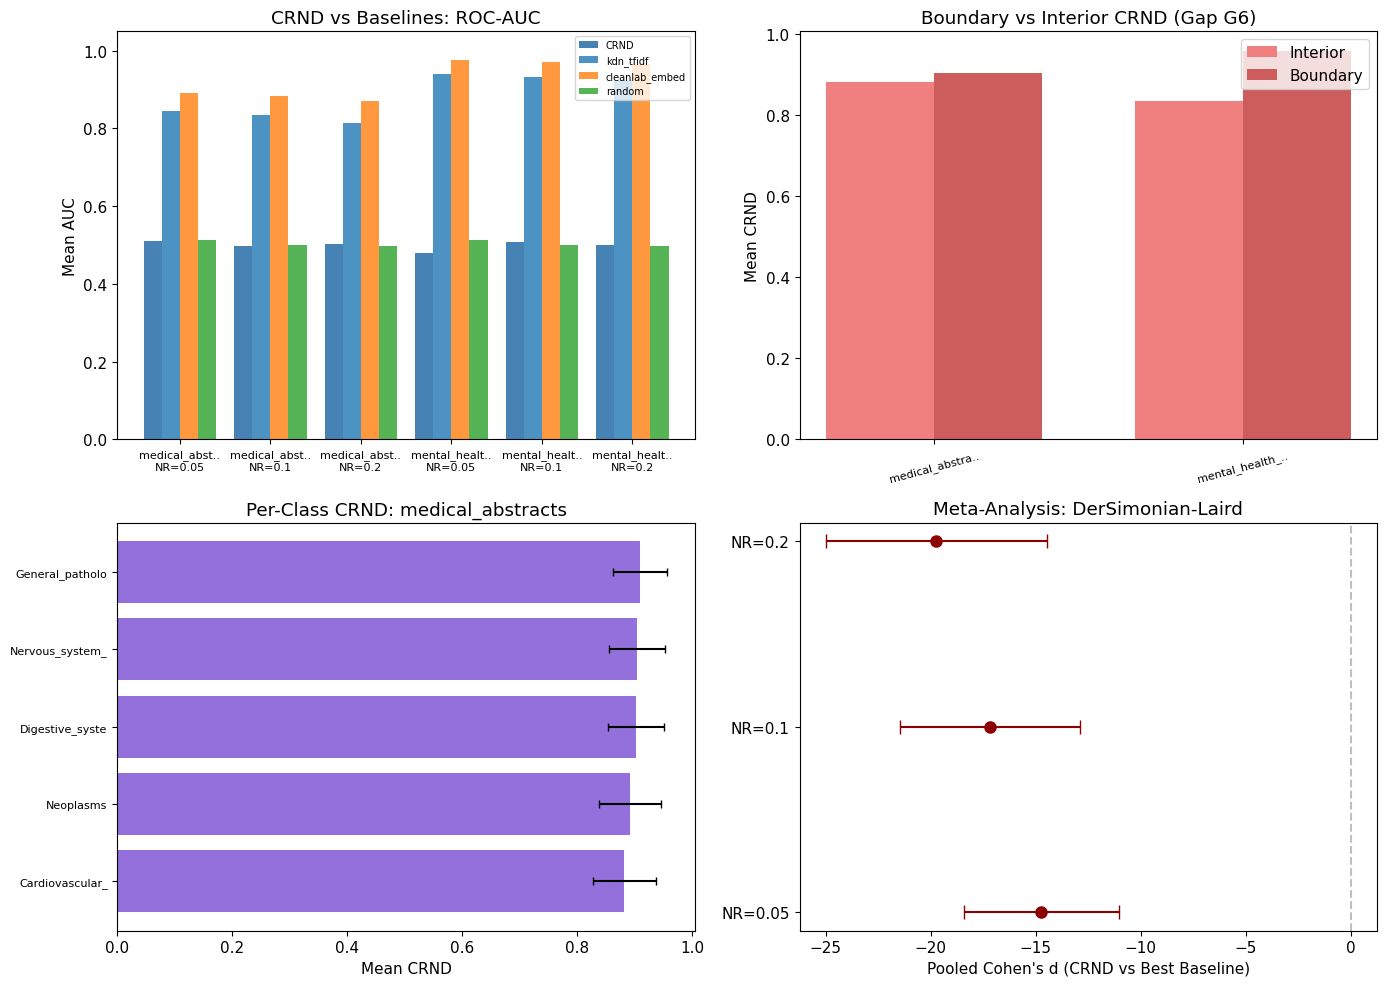

Saved eval_results.png


In [14]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- Figure 1: CRND vs Baselines AUC (grouped bar) ---
ax = axes[0, 0]
group_labels = []
crnd_aucs = []
bl_aucs_dict = {bl: [] for bl in UNIQUE_BASELINES}
for ds in DATASETS:
    for nr in NOISE_RATES:
        crnd = crnd_agg.get(ds, {}).get(nr, {}).get("crnd")
        if crnd is None:
            continue
        short_ds = ds[:12] + ".." if len(ds) > 14 else ds
        group_labels.append(f"{short_ds}\nNR={nr}")
        crnd_aucs.append(crnd["mean_auc"])
        for bl in UNIQUE_BASELINES:
            bl_data = baseline_agg.get(ds, {}).get(nr, {}).get(bl)
            bl_aucs_dict[bl].append(bl_data["mean_auc"] if bl_data else 0)

x = np.arange(len(group_labels))
n_methods = 1 + len(UNIQUE_BASELINES)
width = 0.8 / n_methods
ax.bar(x - width * (n_methods - 1) / 2, crnd_aucs, width, label="CRND", color="steelblue")
for i, bl in enumerate(UNIQUE_BASELINES):
    ax.bar(x - width * (n_methods - 1) / 2 + width * (i + 1), bl_aucs_dict[bl], width,
           label=bl, alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(group_labels, fontsize=8)
ax.set_ylabel("Mean AUC")
ax.set_title("CRND vs Baselines: ROC-AUC")
ax.legend(fontsize=7, loc="upper right")
ax.set_ylim(0, 1.05)

# --- Figure 2: Boundary vs Interior CRND ---
ax = axes[0, 1]
ds_names = list(boundary_results.keys())
interior_vals = [boundary_results[ds]["interior_mean_crnd"] for ds in ds_names]
boundary_vals = [boundary_results[ds]["boundary_mean_crnd"] for ds in ds_names]
x2 = np.arange(len(ds_names))
width2 = 0.35
ax.bar(x2 - width2 / 2, interior_vals, width2, label="Interior", color="lightcoral")
ax.bar(x2 + width2 / 2, boundary_vals, width2, label="Boundary", color="indianred")
ax.set_xticks(x2)
short_ds_names = [ds[:14] + ".." if len(ds) > 16 else ds for ds in ds_names]
ax.set_xticklabels(short_ds_names, fontsize=8, rotation=15)
ax.set_ylabel("Mean CRND")
ax.set_title("Boundary vs Interior CRND (Gap G6)")
ax.legend()

# --- Figure 3: Per-Class CRND ---
ax = axes[1, 0]
first_ds = DATASETS[0]
if first_ds in per_class_results:
    classes = per_class_results[first_ds]["classes_sorted"]
    cls_names = [c["class"][:15] for c in classes]
    cls_means = [c["mean"] for c in classes]
    cls_stds = [c["std"] for c in classes]
    x3 = np.arange(len(cls_names))
    ax.barh(x3, cls_means, xerr=cls_stds, color="mediumpurple", capsize=3)
    ax.set_yticks(x3)
    ax.set_yticklabels(cls_names, fontsize=8)
    ax.set_xlabel("Mean CRND")
    ax.set_title(f"Per-Class CRND: {first_ds}")

# --- Figure 4: Meta-Analysis Forest Plot ---
ax = axes[1, 1]
nr_labels = []
pooled_ds = []
ci_los = []
ci_his = []
for nr in NOISE_RATES:
    if nr in meta_results:
        nr_labels.append(f"NR={nr}")
        pooled_ds.append(meta_results[nr]["pooled_effect"])
        ci_los.append(meta_results[nr]["ci_lower"])
        ci_his.append(meta_results[nr]["ci_upper"])
y_pos = np.arange(len(nr_labels))
errors = [[p - lo for p, lo in zip(pooled_ds, ci_los)],
          [hi - p for p, hi in zip(pooled_ds, ci_his)]]
ax.errorbar(pooled_ds, y_pos, xerr=errors, fmt='o', color='darkred',
            capsize=5, markersize=8)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax.set_yticks(y_pos)
ax.set_yticklabels(nr_labels)
ax.set_xlabel("Pooled Cohen's d (CRND vs Best Baseline)")
ax.set_title("Meta-Analysis: DerSimonian-Laird")

plt.tight_layout()
plt.savefig("eval_results.png", dpi=100, bbox_inches="tight")
plt.show()
print("Saved eval_results.png")